# Statistical Validation for Fetal Head Segmentation Model

This notebook performs comprehensive statistical validation of the MobileNetV2-ASPP-Residual-SE U-Net model on the **TEST SET** according to the requirements:

## Important: Using Test Set
- The **test set** is used for final unbiased evaluation
- The model was selected based on validation set performance
- Test set provides true generalization performance for thesis reporting

## Primary Metrics
- **Sensitivity/Recall**: How many fetal heads did the model detect? (Target: >95%)
- **Specificity**: How often does it avoid false positives? (Target: >98%)
- **Dice Coefficient**: Compare against expert annotations (Target: ≥0.95)

- **Confidence Intervals**: Report uncertainty (e.g., Dice = 0.978 ± 0.012)

## Statistical Tests- **Paired t-test**: Is there systematic bias in model predictions?
- **Bland-Altman Plot**: Agreement between model and human measurements

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm
import yaml

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 2. Load Model and Configuration

In [4]:
# Load model
from efficient_focus.src.models.mobinet_aspp_residual_se.mobinet_aspp_residual_se import MobileNetV2ASPPResidualSEUNet

# Load config
config_path = project_root / 'efficient_focus' / 'configs' / 'mobinet_aspp_residual_se_config_v2.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Model path
model_path = project_root / 'best_models' / 'best_model_mobinet_aspp_residual_se_v2.pth'

# Initialize model
model = MobileNetV2ASPPResidualSEUNet(
    in_channels=config['model']['in_channels'],
    out_channels=config['model']['out_channels'],
    pretrained=config['model']['pretrained'],
    freeze_encoder=config['model']['freeze_encoder'],
    reduction_ratio=config['model']['reduction_ratio'],
    atrous_rates=config['model']['atrous_rates'],
    aspp_dropout=config['model']['aspp_dropout'],
    aspp_use_groupnorm=config['model']['aspp_use_groupnorm']
).to(device)

# Load weights
if model_path.exists():
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
        
        # Handle optional metrics with proper formatting
        train_dice = checkpoint.get('train_dice')
        val_dice = checkpoint.get('val_dice')
        
        if train_dice is not None:
            print(f"  Training Dice: {train_dice:.4f}")
        else:
            print(f"  Training Dice: N/A")
        
        if val_dice is not None:
            print(f"  Validation Dice: {val_dice:.4f}")
        else:
            print(f"  Validation Dice: N/A")
    else:
        model.load_state_dict(checkpoint)
        print("✓ Loaded model weights")
else:
    print(f"⚠ Model not found at {model_path}")
    print("  Please ensure you have the trained model file")

model.eval()
print(f"\n✓ Model loaded successfully")

✓ Loaded model from epoch 48
  Training Dice: N/A
  Validation Dice: N/A

✓ Model loaded successfully


## 3. Dataset Setup

In [10]:
class TestDataset(Dataset):
    """Dataset for test set evaluation with image and mask loading"""
    
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted(list(self.images_dir.glob('*.png')))
        
        # Verify corresponding masks exist
        self.valid_pairs = []
        for img_path in self.image_files:
            mask_path = self.masks_dir / img_path.name
            if mask_path.exists():
                self.valid_pairs.append((img_path, mask_path))
        
        print(f"Found {len(self.valid_pairs)} valid image-mask pairs")
    
    def __len__(self):
        return len(self.valid_pairs)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.valid_pairs[idx]
        
        # Load image (grayscale)
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))
        
        # Load mask (RGB format - extract red channel like in training)
        # Test set masks are RGB with annotations in red channel only
        mask = cv2.imread(str(mask_path))
        if mask is None:
            raise FileNotFoundError(f"Failed to load mask: {mask_path}")
        mask = mask[:, :, 2]  # Extract red channel (BGR format, so index 2)
        mask = cv2.resize(mask, (256, 256))
        
        # Normalize image to [0, 1]
        image = image.astype(np.float32) / 255.0
        
        # Normalize mask to binary [0, 1]
        mask = mask.astype(np.float32) / 255.0
        mask = (mask > 0.5).astype(np.float32)
        
        # Convert to tensors
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dim
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        return {
            'image': image,
            'mask': mask,
            'filename': img_path.name
        }

# Setup test dataset
test_images_dir = project_root / config['data']['test_images']
test_masks_dir = project_root / config['data']['test_masks']

test_dataset = TestDataset(test_images_dir, test_masks_dir)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,  # Process one at a time for detailed statistics
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\n✓ Test dataset ready with {len(test_dataset)} samples")

Found 576 valid image-mask pairs

✓ Test dataset ready with 576 samples


## 4. Metric Computation Functions

In [11]:
def compute_metrics(pred, target, threshold=0.5):
    """
    Compute comprehensive metrics for binary segmentation
    
    Args:
        pred: Predicted mask (H, W) with values in [0, 1]
        target: Ground truth mask (H, W) with binary values {0, 1}
        threshold: Threshold for converting predictions to binary
    
    Returns:
        dict: Dictionary containing all metrics
    """
    # Binarize prediction
    pred_binary = (pred >= threshold).astype(np.uint8)
    target_binary = target.astype(np.uint8)
    
    # Flatten for confusion matrix
    pred_flat = pred_binary.flatten()
    target_flat = target_binary.flatten()
    
    # Confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(target_flat, pred_flat, labels=[0, 1]).ravel()
    
    # Primary metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall / True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate
    
    # Dice coefficient
    intersection = np.sum(pred_binary * target_binary)
    dice = (2.0 * intersection) / (np.sum(pred_binary) + np.sum(target_binary)) if (np.sum(pred_binary) + np.sum(target_binary)) > 0 else 0.0
    
    # IoU
    union = np.sum(pred_binary) + np.sum(target_binary) - intersection
    iou = intersection / union if union > 0 else 0.0
    
    # Precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    
    # F1 Score (same as Dice for binary segmentation)
    f1 = (2.0 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
    
    # Pixel accuracy
    pixel_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
    
    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'dice': dice,
        'iou': iou,
        'precision': precision,
        'f1': f1,
        'pixel_accuracy': pixel_accuracy,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }

def compute_area(mask):
    """Compute area of segmented region (number of positive pixels)"""
    return np.sum(mask > 0)

print("✓ Metric functions defined")

✓ Metric functions defined


## 5. Run Inference and Collect Results

In [12]:
results = []

print("Running inference on test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Processing"):
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)
        filename = batch['filename'][0]
        
        # Forward pass
        output = model(image)
        pred = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        
        # Convert to numpy
        pred_np = pred.cpu().numpy()[0, 0]  # (H, W)
        mask_np = mask.cpu().numpy()[0, 0]  # (H, W)
        
        # Compute metrics
        metrics = compute_metrics(pred_np, mask_np)
        
        # Compute areas for Bland-Altman analysis
        pred_area = compute_area(pred_np >= 0.5)
        gt_area = compute_area(mask_np)
        
        # Store results
        result = {
            'filename': filename,
            'pred_area': pred_area,
            'gt_area': gt_area,
            **metrics
        }
        results.append(result)

# Convert to DataFrame
df_results = pd.DataFrame(results)

print(f"\n✓ Processed {len(df_results)} samples")
print(f"\nSample results:")
print(df_results.head())

Running inference on test set...


Processing: 100%|██████████| 576/576 [01:44<00:00,  5.52it/s]



✓ Processed 576 samples

Sample results:
      filename  pred_area  gt_area  sensitivity  specificity      dice  \
0   005_HC.png       4092     4181     0.947620     0.997881  0.957815   
1  019_2HC.png       3925     4317     0.899467     0.999314  0.942247   
2   019_HC.png       4120     4408     0.906987     0.998004  0.937617   
3   027_HC.png       6115     5906     0.978496     0.994365  0.961484   
4   028_HC.png       6315     6344     0.951608     0.995303  0.953788   

        iou  precision        f1  pixel_accuracy    tp     tn   fp   fn  
0  0.919044   0.968231  0.957815        0.994675  3962  61225  130  219  
1  0.890801   0.989299  0.942247        0.992737  3883  61177   42  434  
2  0.882561   0.970388  0.937617        0.991882  3998  61006  122  410  
3  0.925825   0.945053  0.961484        0.992935  5779  59294  336  127  
4  0.911658   0.955978  0.953788        0.991074  6037  58914  278  307  


## 6. Primary Metrics Analysis

In [13]:
# Compute statistics for primary metrics
primary_metrics = ['sensitivity', 'specificity', 'dice']

print("=" * 80)
print("PRIMARY METRICS ANALYSIS")
print("=" * 80)

for metric in primary_metrics:
    values = df_results[metric].values
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    min_val = np.min(values)
    max_val = np.max(values)
    
    # 95% Confidence Interval
    ci_95 = 1.96 * std / np.sqrt(len(values))
    
    # Target thresholds
    targets = {
        'sensitivity': 0.95,
        'specificity': 0.98,
        'dice': 0.95
    }
    
    target = targets.get(metric, 0.0)
    passed = "✓ PASS" if mean >= target else "✗ FAIL"
    
    print(f"\n{metric.upper()}:")
    print(f"  Mean:              {mean:.4f} ({mean*100:.2f}%)")
    print(f"  Std Dev:           {std:.4f}")
    print(f"  Median:            {median:.4f}")
    print(f"  Range:             [{min_val:.4f}, {max_val:.4f}]")
    print(f"  95% CI:            {mean:.4f} ± {ci_95:.4f}")
    print(f"  Target:            ≥{target:.4f} ({target*100:.0f}%)")
    print(f"  Status:            {passed}")

print("\n" + "=" * 80)
print("ADDITIONAL METRICS")
print("=" * 80)

additional_metrics = ['iou', 'precision', 'f1', 'pixel_accuracy']
for metric in additional_metrics:
    mean = np.mean(df_results[metric])
    std = np.std(df_results[metric])
    ci_95 = 1.96 * std / np.sqrt(len(df_results))
    print(f"{metric.upper():20s}: {mean:.4f} ± {ci_95:.4f} ({mean*100:.2f}%)")

print("=" * 80)

PRIMARY METRICS ANALYSIS

SENSITIVITY:
  Mean:              0.9775 (97.75%)
  Std Dev:           0.0473
  Median:            0.9865
  Range:             [0.0000, 1.0000]
  95% CI:            0.9775 ± 0.0039
  Target:            ≥0.9500 (95%)
  Status:            ✓ PASS

SPECIFICITY:
  Mean:              0.9815 (98.15%)
  Std Dev:           0.0201
  Median:            0.9867
  Range:             [0.7423, 1.0000]
  95% CI:            0.9815 ± 0.0016
  Target:            ≥0.9800 (98%)
  Status:            ✓ PASS

DICE:
  Mean:              0.9710 (97.10%)
  Std Dev:           0.0425
  Median:            0.9757
  Range:             [0.0000, 0.9926]
  95% CI:            0.9710 ± 0.0035
  Target:            ≥0.9500 (95%)
  Status:            ✓ PASS

ADDITIONAL METRICS
IOU                 : 0.9455 ± 0.0038 (94.55%)
PRECISION           : 0.9654 ± 0.0038 (96.54%)
F1                  : 0.9710 ± 0.0035 (97.10%)
PIXEL_ACCURACY      : 0.9817 ± 0.0009 (98.17%)


## 7. Bland-Altman Plot

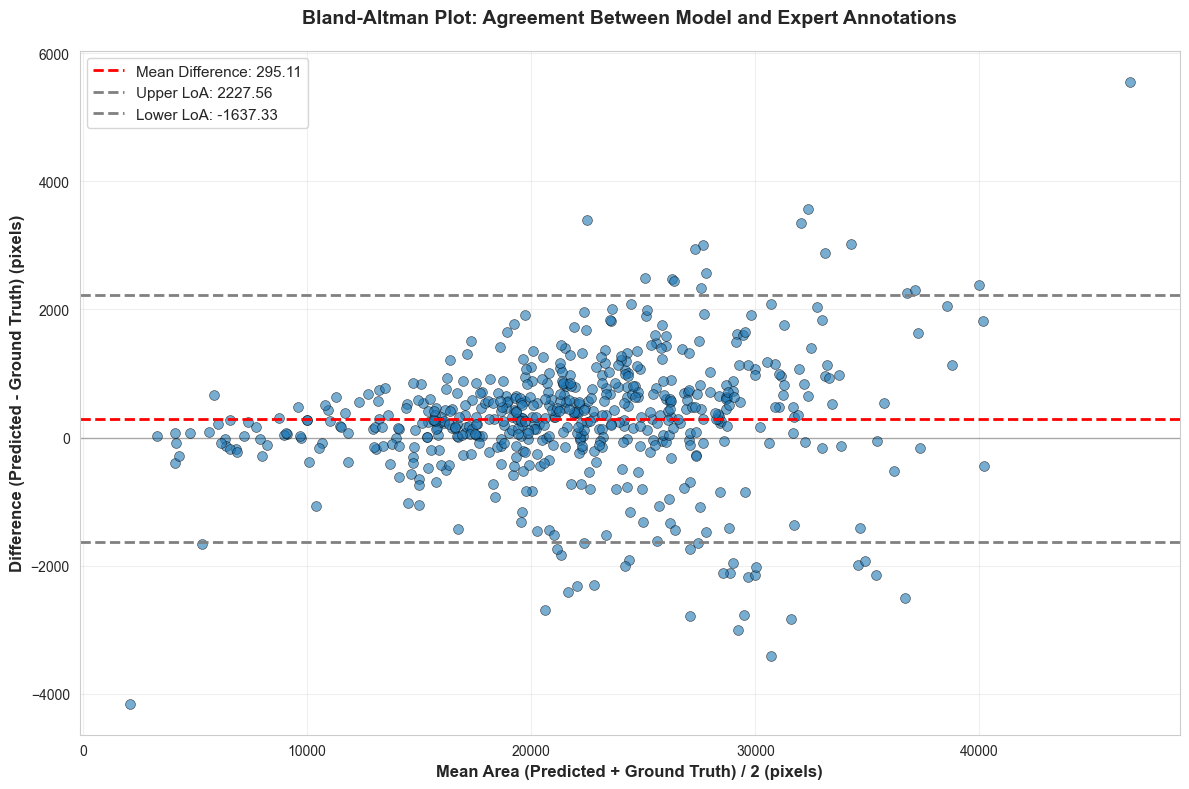

BLAND-ALTMAN ANALYSIS
Mean Difference (Bias):        295.11 pixels
Standard Deviation:             985.94 pixels
Upper Limit of Agreement:       2227.56 pixels
Lower Limit of Agreement:       -1637.33 pixels
95% of differences lie within:  [-1637.33, 2227.56] pixels
⚠ Systematic bias detected - model tends to over-segment


In [14]:
# Bland-Altman analysis for area measurements
mean_area = (df_results['pred_area'] + df_results['gt_area']) / 2
diff_area = df_results['pred_area'] - df_results['gt_area']

# Calculate statistics
mean_diff = np.mean(diff_area)
std_diff = np.std(diff_area)
upper_loa = mean_diff + 1.96 * std_diff  # Upper limit of agreement
lower_loa = mean_diff - 1.96 * std_diff  # Lower limit of agreement

# Create Bland-Altman plot
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(mean_area, diff_area, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
ax.axhline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean Difference: {mean_diff:.2f}')
ax.axhline(upper_loa, color='gray', linestyle='--', linewidth=2, label=f'Upper LoA: {upper_loa:.2f}')
ax.axhline(lower_loa, color='gray', linestyle='--', linewidth=2, label=f'Lower LoA: {lower_loa:.2f}')
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

ax.set_xlabel('Mean Area (Predicted + Ground Truth) / 2 (pixels)', fontsize=12, fontweight='bold')
ax.set_ylabel('Difference (Predicted - Ground Truth) (pixels)', fontsize=12, fontweight='bold')
ax.set_title('Bland-Altman Plot: Agreement Between Model and Expert Annotations', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("=" * 80)
print("BLAND-ALTMAN ANALYSIS")
print("=" * 80)
print(f"Mean Difference (Bias):        {mean_diff:.2f} pixels")
print(f"Standard Deviation:             {std_diff:.2f} pixels")
print(f"Upper Limit of Agreement:       {upper_loa:.2f} pixels")
print(f"Lower Limit of Agreement:       {lower_loa:.2f} pixels")
print(f"95% of differences lie within:  [{lower_loa:.2f}, {upper_loa:.2f}] pixels")
print("=" * 80)

# Interpretation
if abs(mean_diff) < 100:  # Small bias threshold
    print("✓ Low systematic bias detected")
else:
    print("⚠ Systematic bias detected - model tends to", 
          "over-segment" if mean_diff > 0 else "under-segment")

## 8. Paired t-test for Systematic Bias

In [15]:
# Perform paired t-test on area measurements
t_stat_area, p_value_area = stats.ttest_rel(df_results['pred_area'], df_results['gt_area'])

print("=" * 80)
print("PAIRED T-TEST: AREA MEASUREMENTS")
print("=" * 80)
print(f"Null Hypothesis: Mean difference between predicted and ground truth areas = 0")
print(f"Alternative Hypothesis: Mean difference ≠ 0 (systematic bias exists)")
print()
print(f"t-statistic:           {t_stat_area:.4f}")
print(f"p-value:               {p_value_area:.6f}")
print(f"Significance level:    α = 0.05")
print()

if p_value_area < 0.05:
    print(f"✗ REJECT null hypothesis (p < 0.05)")
    print(f"  Conclusion: Systematic bias detected in area measurements")
else:
    print(f"✓ FAIL TO REJECT null hypothesis (p ≥ 0.05)")
    print(f"  Conclusion: No significant systematic bias detected")
print("=" * 80)

# Paired t-test on Dice coefficients (comparing to perfect score of 1.0)
perfect_dice = np.ones_like(df_results['dice'])
t_stat_dice, p_value_dice = stats.ttest_rel(df_results['dice'], perfect_dice)

print("\nPAIRED T-TEST: DICE COEFFICIENT vs PERFECT SCORE (1.0)")
print("=" * 80)
print(f"Null Hypothesis: Mean Dice = 1.0 (perfect segmentation)")
print(f"Alternative Hypothesis: Mean Dice ≠ 1.0")
print()
print(f"t-statistic:           {t_stat_dice:.4f}")
print(f"p-value:               {p_value_dice:.6f}")
print(f"Mean Dice:             {np.mean(df_results['dice']):.4f}")
print()

if p_value_dice < 0.05:
    print(f"✗ REJECT null hypothesis (p < 0.05)")
    print(f"  Conclusion: Model does not achieve perfect segmentation")
    print(f"  (This is expected - no model is perfect)")
else:
    print(f"✓ FAIL TO REJECT null hypothesis (p ≥ 0.05)")
    print(f"  Conclusion: No significant difference from perfect segmentation")
print("=" * 80)

PAIRED T-TEST: AREA MEASUREMENTS
Null Hypothesis: Mean difference between predicted and ground truth areas = 0
Alternative Hypothesis: Mean difference ≠ 0 (systematic bias exists)

t-statistic:           7.1775
p-value:               0.000000
Significance level:    α = 0.05

✗ REJECT null hypothesis (p < 0.05)
  Conclusion: Systematic bias detected in area measurements

PAIRED T-TEST: DICE COEFFICIENT vs PERFECT SCORE (1.0)
Null Hypothesis: Mean Dice = 1.0 (perfect segmentation)
Alternative Hypothesis: Mean Dice ≠ 1.0

t-statistic:           -16.3370
p-value:               0.000000
Mean Dice:             0.9710

✗ REJECT null hypothesis (p < 0.05)
  Conclusion: Model does not achieve perfect segmentation
  (This is expected - no model is perfect)


## 9. Confidence Intervals for All Metrics

CONFIDENCE INTERVALS (95%)
Metric               Mean         Std Dev      95% CI                   
--------------------------------------------------------------------------------
sensitivity          0.9775       0.0473       [0.9736, 0.9814]
specificity          0.9815       0.0201       [0.9798, 0.9831]
dice                 0.9710       0.0425       [0.9675, 0.9745]
iou                  0.9455       0.0461       [0.9418, 0.9493]
precision            0.9654       0.0460       [0.9617, 0.9692]
f1                   0.9710       0.0425       [0.9675, 0.9745]
pixel_accuracy       0.9817       0.0110       [0.9808, 0.9826]


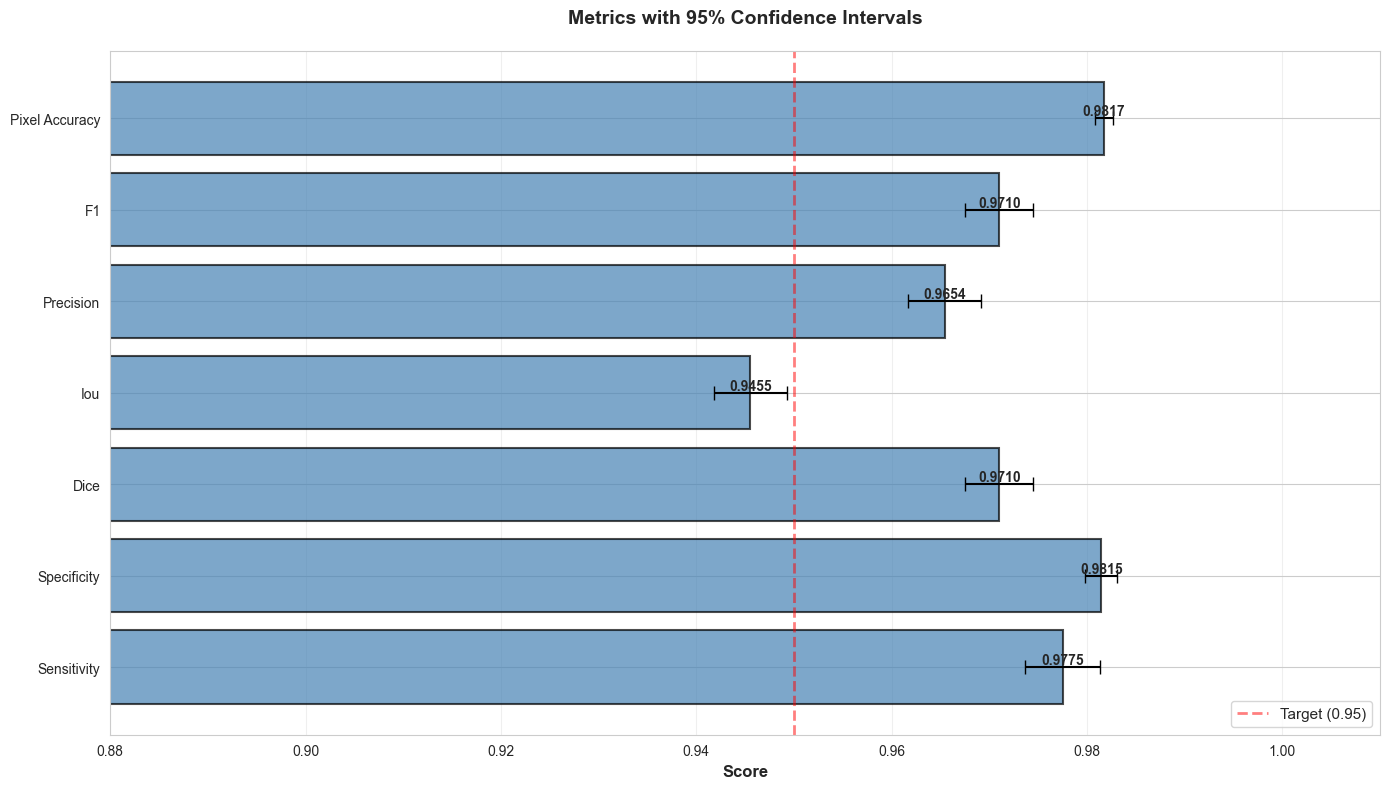

In [16]:
# Compute 95% confidence intervals for all metrics
metrics_to_report = ['sensitivity', 'specificity', 'dice', 'iou', 'precision', 'f1', 'pixel_accuracy']

print("=" * 80)
print("CONFIDENCE INTERVALS (95%)")
print("=" * 80)
print(f"{'Metric':<20s} {'Mean':<12s} {'Std Dev':<12s} {'95% CI':<25s}")
print("-" * 80)

ci_results = {}
for metric in metrics_to_report:
    values = df_results[metric].values
    mean = np.mean(values)
    std = np.std(values)
    
    # 95% CI using t-distribution (more accurate for smaller samples)
    n = len(values)
    se = std / np.sqrt(n)  # Standard error
    ci_margin = stats.t.ppf(0.975, n-1) * se  # t-score for 95% CI
    
    ci_lower = mean - ci_margin
    ci_upper = mean + ci_margin
    
    ci_results[metric] = {
        'mean': mean,
        'std': std,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'ci_margin': ci_margin
    }
    
    print(f"{metric:<20s} {mean:<12.4f} {std:<12.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

print("=" * 80)

# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(14, 8))

y_pos = np.arange(len(metrics_to_report))
means = [ci_results[m]['mean'] for m in metrics_to_report]
errors = [ci_results[m]['ci_margin'] for m in metrics_to_report]

bars = ax.barh(y_pos, means, xerr=errors, capsize=5, alpha=0.7, 
               color='steelblue', edgecolor='black', linewidth=1.5)

# Add value labels
for i, (metric, bar) in enumerate(zip(metrics_to_report, bars)):
    mean = ci_results[metric]['mean']
    ci_lower = ci_results[metric]['ci_lower']
    ci_upper = ci_results[metric]['ci_upper']
    ax.text(mean, i, f'{mean:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels([m.replace('_', ' ').title() for m in metrics_to_report])
ax.set_xlabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Metrics with 95% Confidence Intervals', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0.88, 1.01)
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(0.95, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.95)')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

## 10. Distribution Analysis

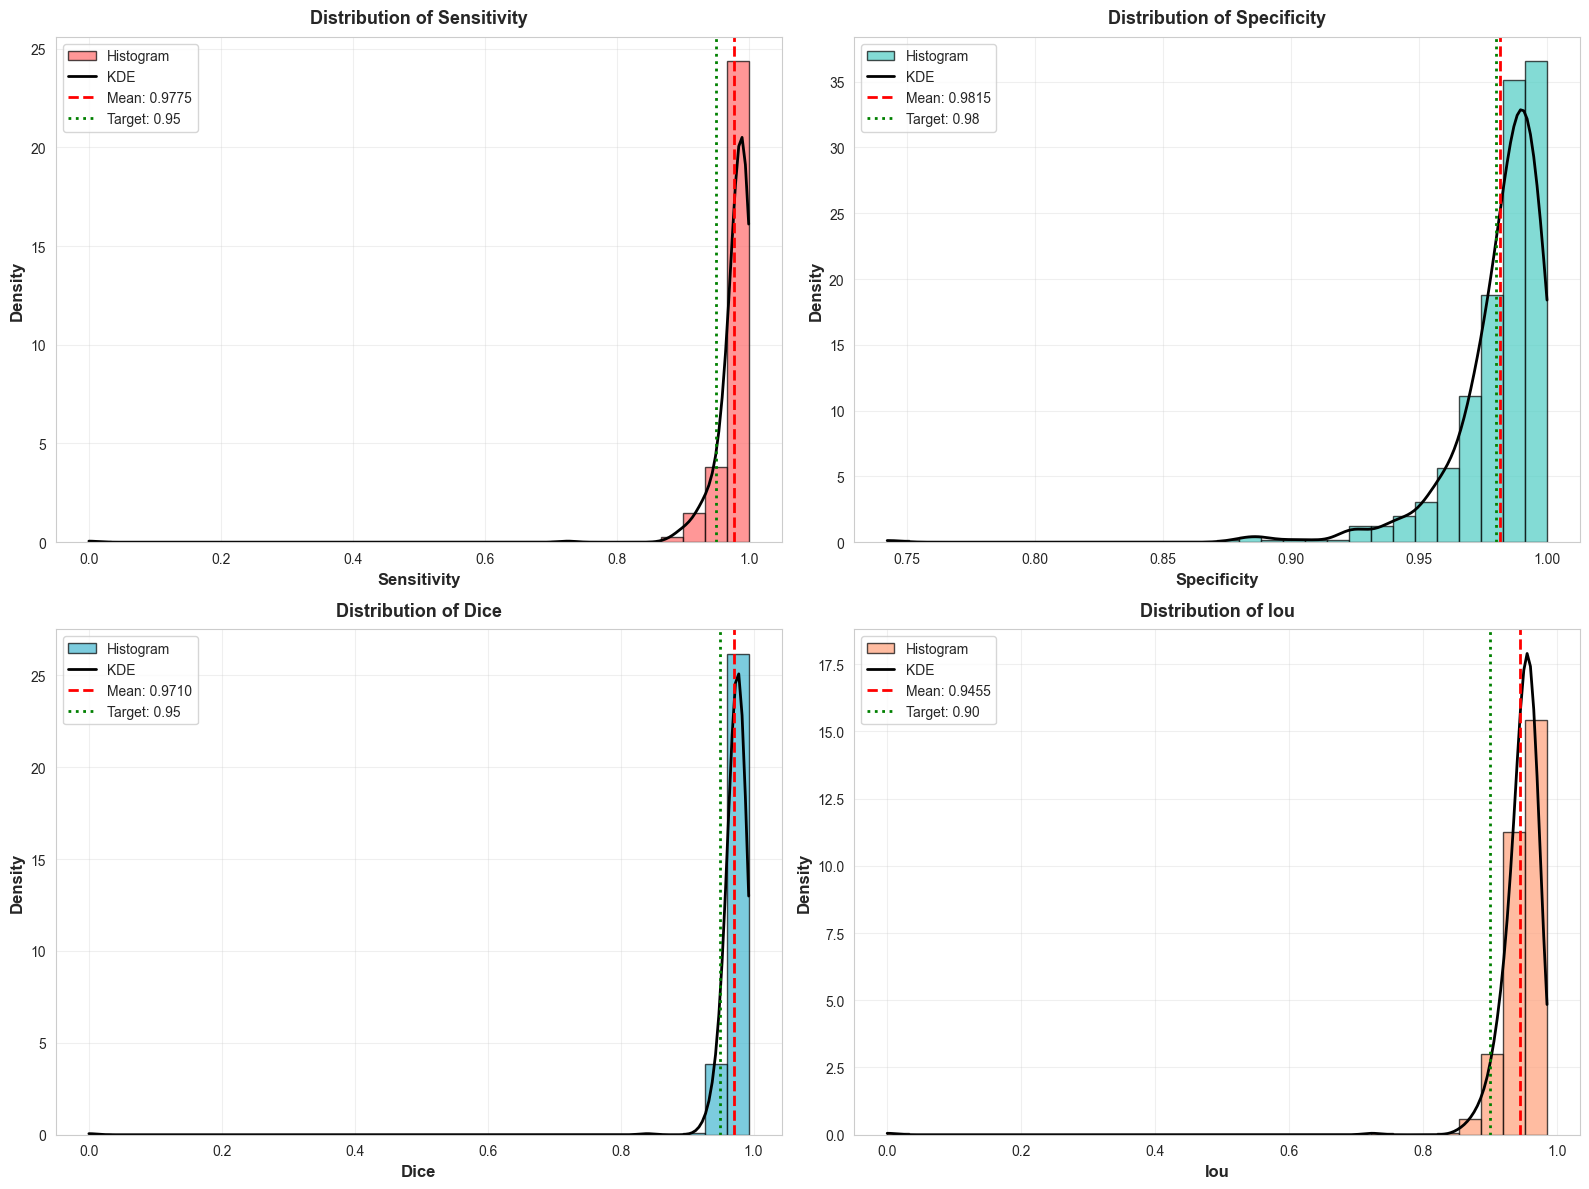

NORMALITY TESTS (Shapiro-Wilk)
SENSITIVITY    : W=0.2905, p=0.000000 → Not Normal
SPECIFICITY    : W=0.6852, p=0.000000 → Not Normal
DICE           : W=0.1629, p=0.000000 → Not Normal
IOU            : W=0.3459, p=0.000000 → Not Normal


In [17]:
# Visualize distributions of primary metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metrics_to_plot = ['sensitivity', 'specificity', 'dice', 'iou']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]
    values = df_results[metric].values
    
    # Histogram with KDE
    ax.hist(values, bins=30, alpha=0.7, color=color, edgecolor='black', 
            density=True, label='Histogram')
    
    # KDE overlay
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(values)
    x_range = np.linspace(values.min(), values.max(), 200)
    ax.plot(x_range, kde(x_range), 'k-', linewidth=2, label='KDE')
    
    # Add mean line
    mean_val = np.mean(values)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.4f}')
    
    # Add target line if applicable
    targets = {'sensitivity': 0.95, 'specificity': 0.98, 'dice': 0.95, 'iou': 0.90}
    if metric in targets:
        ax.axvline(targets[metric], color='green', linestyle=':', linewidth=2, 
                   label=f'Target: {targets[metric]:.2f}')
    
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution of {metric.replace("_", " ").title()}', 
                 fontsize=13, fontweight='bold', pad=10)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normality tests
print("=" * 80)
print("NORMALITY TESTS (Shapiro-Wilk)")
print("=" * 80)
for metric in metrics_to_plot:
    stat, p_value = stats.shapiro(df_results[metric].values)
    normality = "Normal" if p_value > 0.05 else "Not Normal"
    print(f"{metric.upper():<15s}: W={stat:.4f}, p={p_value:.6f} → {normality}")
print("=" * 80)

## 11. Box Plots for Metric Comparison

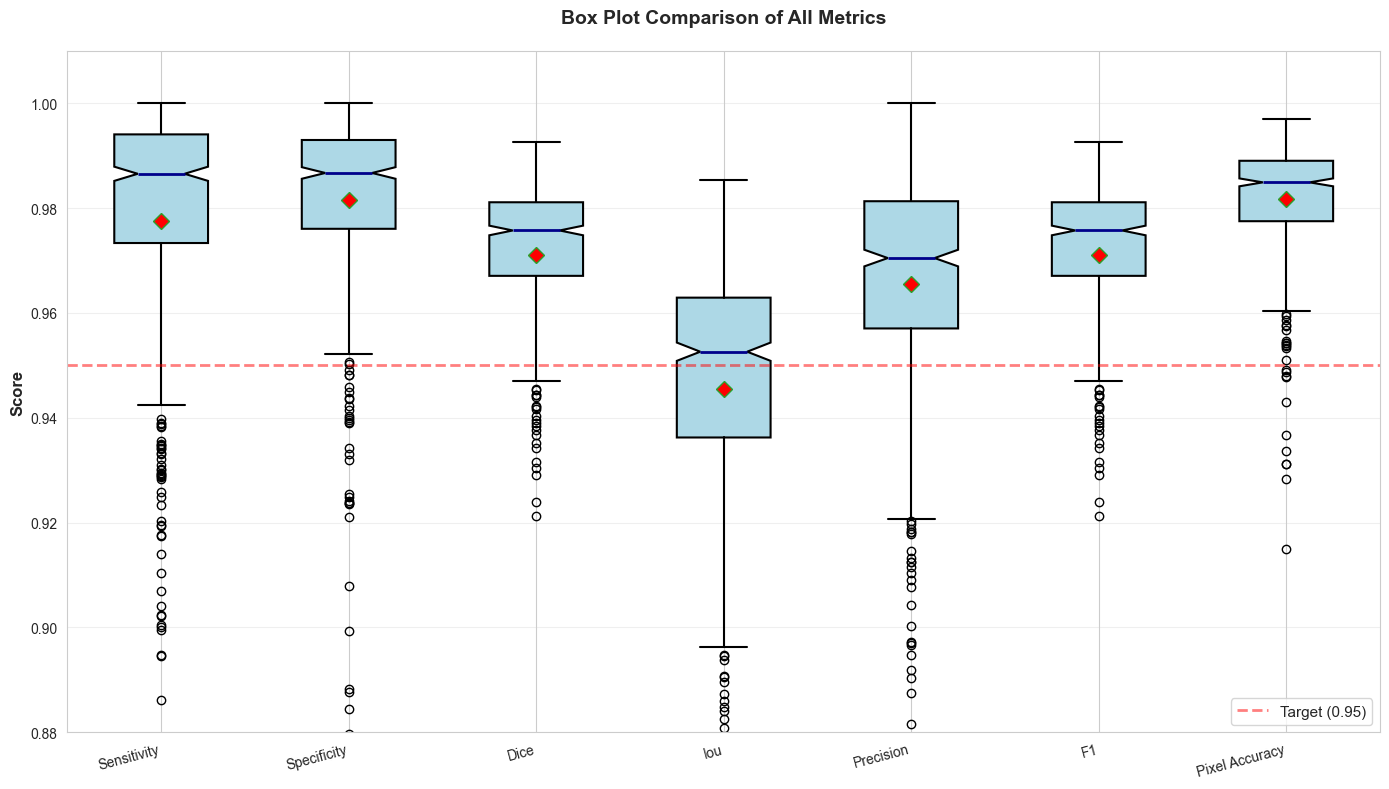

QUARTILE STATISTICS
SENSITIVITY         : Q1=0.9733, Median=0.9865, Q3=0.9941, IQR=0.0207
SPECIFICITY         : Q1=0.9760, Median=0.9867, Q3=0.9930, IQR=0.0169
DICE                : Q1=0.9671, Median=0.9757, Q3=0.9811, IQR=0.0140
IOU                 : Q1=0.9362, Median=0.9526, Q3=0.9629, IQR=0.0267
PRECISION           : Q1=0.9570, Median=0.9705, Q3=0.9813, IQR=0.0243
F1                  : Q1=0.9671, Median=0.9757, Q3=0.9811, IQR=0.0140
PIXEL_ACCURACY      : Q1=0.9775, Median=0.9849, Q3=0.9890, IQR=0.0115


In [18]:
# Box plot comparison of all metrics
fig, ax = plt.subplots(figsize=(14, 8))

metrics_for_box = ['sensitivity', 'specificity', 'dice', 'iou', 'precision', 'f1', 'pixel_accuracy']
data_for_box = [df_results[m].values for m in metrics_for_box]

bp = ax.boxplot(data_for_box, labels=[m.replace('_', ' ').title() for m in metrics_for_box],
                patch_artist=True, notch=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                medianprops=dict(color='darkblue', linewidth=2),
                boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5))

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Box Plot Comparison of All Metrics', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0.88, 1.01)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0.95, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Target (0.95)')
ax.legend(loc='lower right', fontsize=11)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

# Print quartile statistics
print("=" * 80)
print("QUARTILE STATISTICS")
print("=" * 80)
for metric in metrics_for_box:
    values = df_results[metric].values
    q1, median, q3 = np.percentile(values, [25, 50, 75])
    iqr = q3 - q1
    print(f"{metric.upper():<20s}: Q1={q1:.4f}, Median={median:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}")
print("=" * 80)

## 12. Correlation Analysis

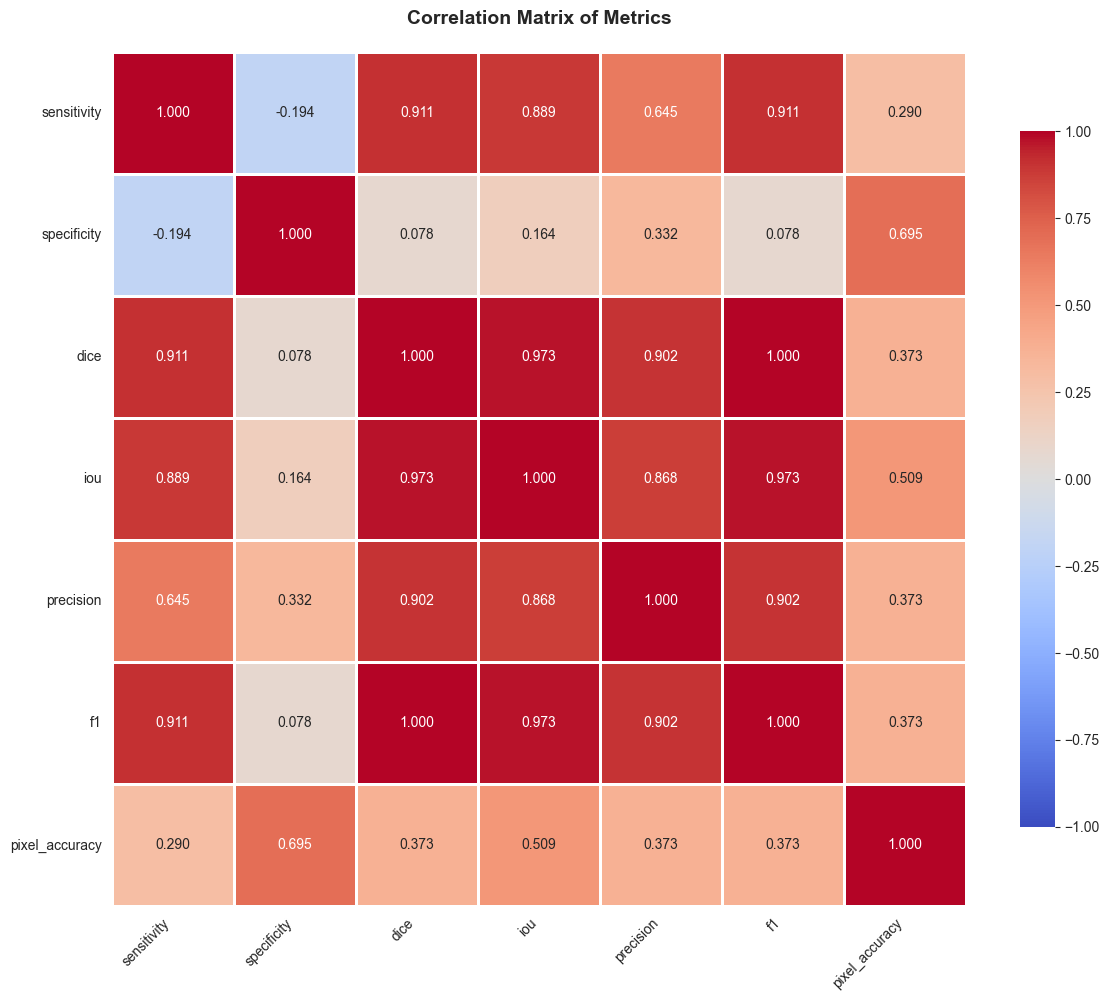

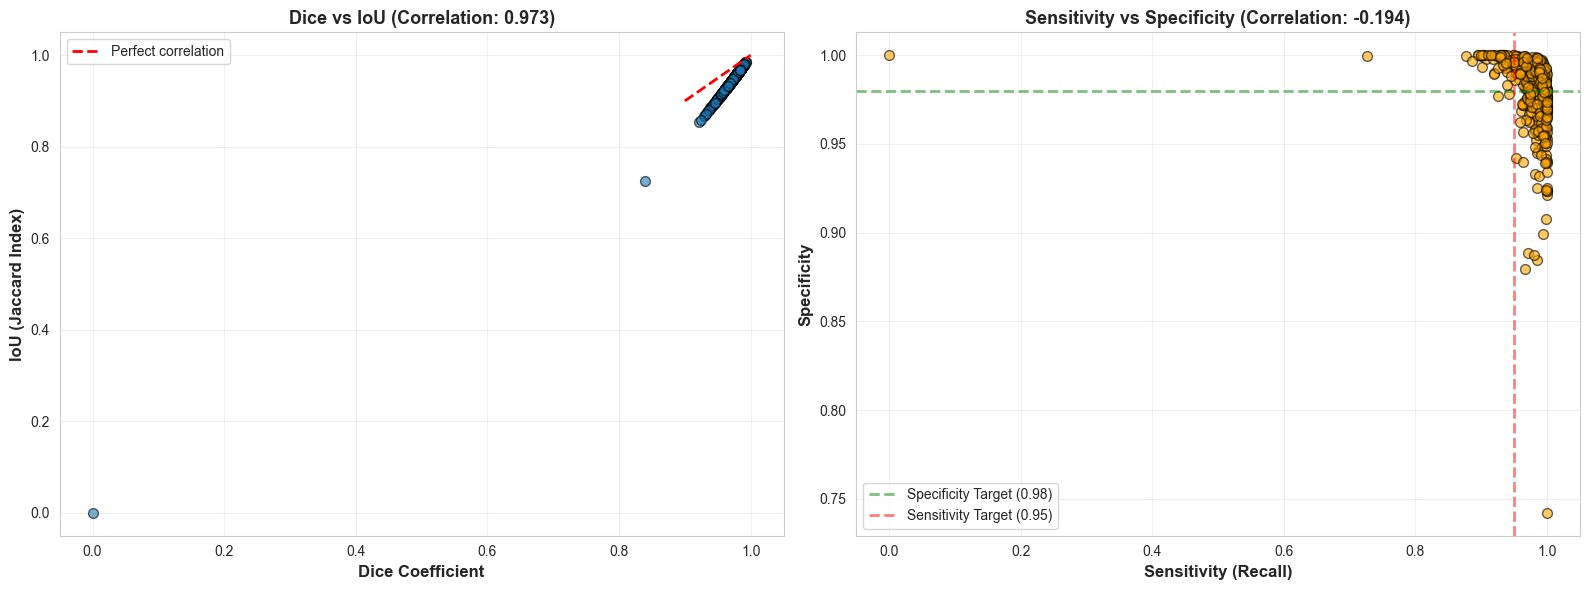

In [19]:
# Correlation matrix of metrics
corr_metrics = ['sensitivity', 'specificity', 'dice', 'iou', 'precision', 'f1', 'pixel_accuracy']
corr_matrix = df_results[corr_metrics].corr()

# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix of Metrics', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Scatter plot: Dice vs IoU (highly correlated)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dice vs IoU
axes[0].scatter(df_results['dice'], df_results['iou'], alpha=0.6, s=50, edgecolors='black')
axes[0].plot([0.9, 1.0], [0.9, 1.0], 'r--', linewidth=2, label='Perfect correlation')
axes[0].set_xlabel('Dice Coefficient', fontsize=12, fontweight='bold')
axes[0].set_ylabel('IoU (Jaccard Index)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Dice vs IoU (Correlation: {corr_matrix.loc["dice", "iou"]:.3f})', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Sensitivity vs Specificity
axes[1].scatter(df_results['sensitivity'], df_results['specificity'], alpha=0.6, s=50, 
                edgecolors='black', color='orange')
axes[1].axhline(0.98, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Specificity Target (0.98)')
axes[1].axvline(0.95, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Sensitivity Target (0.95)')
axes[1].set_xlabel('Sensitivity (Recall)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Specificity', fontsize=12, fontweight='bold')
axes[1].set_title(f'Sensitivity vs Specificity (Correlation: {corr_matrix.loc["sensitivity", "specificity"]:.3f})', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 13. Summary Report

In [20]:
print("\n" + "="*80)
print(" " * 20 + "STATISTICAL VALIDATION SUMMARY REPORT")
print(" " * 25 + "(TEST SET EVALUATION)")
print("="*80)
print(f"\nModel: MobileNetV2-ASPP-Residual-SE U-Net")
print(f"Test Samples: {len(df_results)}")
print(f"Image Size: 256×256 pixels")
print(f"Device: {device}")

print("\n" + "-"*80)
print("PRIMARY METRICS (with 95% Confidence Intervals)")
print("-"*80)

for metric in ['sensitivity', 'specificity', 'dice']:
    mean = ci_results[metric]['mean']
    ci_lower = ci_results[metric]['ci_lower']
    ci_upper = ci_results[metric]['ci_upper']
    
    targets = {'sensitivity': 0.95, 'specificity': 0.98, 'dice': 0.95}
    target = targets[metric]
    status = "✓ PASS" if mean >= target else "✗ FAIL"
    
    print(f"\n{metric.upper()}:")
    print(f"  Result:  {mean:.4f} ± {ci_results[metric]['ci_margin']:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
    print(f"  Target:  ≥{target:.2f}")
    print(f"  Status:  {status}")

print("\n" + "-"*80)
print("ADDITIONAL METRICS")
print("-"*80)

for metric in ['iou', 'precision', 'f1', 'pixel_accuracy']:
    mean = ci_results[metric]['mean']
    ci_lower = ci_results[metric]['ci_lower']
    ci_upper = ci_results[metric]['ci_upper']
    print(f"{metric.upper():<20s}: {mean:.4f} ± {ci_results[metric]['ci_margin']:.4f}")

print("\n" + "-"*80)
print("BLAND-ALTMAN ANALYSIS")
print("-"*80)
print(f"Mean Bias (Predicted - GT):    {mean_diff:.2f} pixels")
print(f"Limits of Agreement:           [{lower_loa:.2f}, {upper_loa:.2f}] pixels")
bias_status = "Low" if abs(mean_diff) < 100 else "Moderate/High"
print(f"Bias Assessment:               {bias_status}")

print("\n" + "-"*80)
print("PAIRED T-TEST (Systematic Bias)")
print("-"*80)
print(f"Area Measurements:")
print(f"  t-statistic: {t_stat_area:.4f}")
print(f"  p-value:     {p_value_area:.6f}")
print(f"  Result:      {'No significant bias' if p_value_area >= 0.05 else 'Significant bias detected'}")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

# Overall assessment
sens_pass = ci_results['sensitivity']['mean'] >= 0.95
spec_pass = ci_results['specificity']['mean'] >= 0.98
dice_pass = ci_results['dice']['mean'] >= 0.95

if sens_pass and spec_pass and dice_pass:
    print("✓ MODEL PASSES all primary metric requirements")
    print(f"  • Sensitivity: {ci_results['sensitivity']['mean']*100:.2f}% (target: ≥95%)")
    print(f"  • Specificity: {ci_results['specificity']['mean']*100:.2f}% (target: ≥98%)")
    print(f"  • Dice Score:  {ci_results['dice']['mean']*100:.2f}% (target: ≥95%)")
else:
    print("⚠ MODEL DOES NOT MEET all requirements:")
    if not sens_pass:
        print(f"  ✗ Sensitivity: {ci_results['sensitivity']['mean']*100:.2f}% < 95%")
    if not spec_pass:
        print(f"  ✗ Specificity: {ci_results['specificity']['mean']*100:.2f}% < 98%")
    if not dice_pass:
        print(f"  ✗ Dice Score: {ci_results['dice']['mean']*100:.2f}% < 95%")

print("\n" + "="*80)

# Save results to CSV
output_dir = project_root / 'notebooks' / 'efficient_focus' / 'mobinet_aspp_residual_se'
df_results.to_csv(output_dir / 'test_set_statistical_validation_results.csv', index=False)
print(f"\n✓ Results saved to: {output_dir / 'test_set_statistical_validation_results.csv'}")
print(f"\n✓ Results saved to: {output_dir / 'statistical_validation_results.csv'}")


                    STATISTICAL VALIDATION SUMMARY REPORT
                         (TEST SET EVALUATION)

Model: MobileNetV2-ASPP-Residual-SE U-Net
Test Samples: 576
Image Size: 256×256 pixels
Device: cpu

--------------------------------------------------------------------------------
PRIMARY METRICS (with 95% Confidence Intervals)
--------------------------------------------------------------------------------

SENSITIVITY:
  Result:  0.9775 ± 0.0039 (95% CI: [0.9736, 0.9814])
  Target:  ≥0.95
  Status:  ✓ PASS

SPECIFICITY:
  Result:  0.9815 ± 0.0016 (95% CI: [0.9798, 0.9831])
  Target:  ≥0.98
  Status:  ✓ PASS

DICE:
  Result:  0.9710 ± 0.0035 (95% CI: [0.9675, 0.9745])
  Target:  ≥0.95
  Status:  ✓ PASS

--------------------------------------------------------------------------------
ADDITIONAL METRICS
--------------------------------------------------------------------------------
IOU                 : 0.9455 ± 0.0038
PRECISION           : 0.9654 ± 0.0038
F1                  : 0

## 14. Export Summary Statistics Table

In [21]:
# Create summary statistics table
summary_stats = []

for metric in metrics_to_report:
    mean = ci_results[metric]['mean']
    std = ci_results[metric]['std']
    ci_lower = ci_results[metric]['ci_lower']
    ci_upper = ci_results[metric]['ci_upper']
    
    values = df_results[metric].values
    min_val = np.min(values)
    max_val = np.max(values)
    median = np.median(values)
    q1, q3 = np.percentile(values, [25, 75])
    
    summary_stats.append({
        'Metric': metric.replace('_', ' ').title(),
        'Mean': f"{mean:.4f}",
        'Std Dev': f"{std:.4f}",
        '95% CI': f"[{ci_lower:.4f}, {ci_upper:.4f}]",
        'Median': f"{median:.4f}",
        'Q1': f"{q1:.4f}",
        'Q3': f"{q3:.4f}",
        'Min': f"{min_val:.4f}",
        'Max': f"{max_val:.4f}"
    })

df_summary = pd.DataFrame(summary_stats)

print("SUMMARY STATISTICS TABLE")
print("="*120)
print(df_summary.to_string(index=False))
print("="*120)

# Save to CSV
df_summary.to_csv(output_dir / 'test_set_summary_statistics.csv', index=False)
print(f"\n✓ Summary statistics saved to: {output_dir / 'test_set_summary_statistics.csv'}")

# Display as formatted table
from IPython.display import display, HTML
display(HTML(df_summary.to_html(index=False)))

SUMMARY STATISTICS TABLE
        Metric   Mean Std Dev           95% CI Median     Q1     Q3    Min    Max
   Sensitivity 0.9775  0.0473 [0.9736, 0.9814] 0.9865 0.9733 0.9941 0.0000 1.0000
   Specificity 0.9815  0.0201 [0.9798, 0.9831] 0.9867 0.9760 0.9930 0.7423 1.0000
          Dice 0.9710  0.0425 [0.9675, 0.9745] 0.9757 0.9671 0.9811 0.0000 0.9926
           Iou 0.9455  0.0461 [0.9418, 0.9493] 0.9526 0.9362 0.9629 0.0000 0.9853
     Precision 0.9654  0.0460 [0.9617, 0.9692] 0.9705 0.9570 0.9813 0.0000 1.0000
            F1 0.9710  0.0425 [0.9675, 0.9745] 0.9757 0.9671 0.9811 0.0000 0.9926
Pixel Accuracy 0.9817  0.0110 [0.9808, 0.9826] 0.9849 0.9775 0.9890 0.9149 0.9969

✓ Summary statistics saved to: e:\Fetal Head Segmentation\notebooks\efficient_focus\mobinet_aspp_residual_se\test_set_summary_statistics.csv


Metric,Mean,Std Dev,95% CI,Median,Q1,Q3,Min,Max
Sensitivity,0.9775,0.0473,"[0.9736, 0.9814]",0.9865,0.9733,0.9941,0.0000,1.0000
Specificity,0.9815,0.0201,"[0.9798, 0.9831]",0.9867,0.9760,0.9930,0.7423,1.0000
Dice,0.9710,0.0425,"[0.9675, 0.9745]",0.9757,0.9671,0.9811,0.0000,0.9926
Iou,0.9455,0.0461,"[0.9418, 0.9493]",0.9526,0.9362,0.9629,0.0000,0.9853
Precision,0.9654,0.0460,"[0.9617, 0.9692]",0.9705,0.9570,0.9813,0.0000,1.0000
F1,0.9710,0.0425,"[0.9675, 0.9745]",0.9757,0.9671,0.9811,0.0000,0.9926
Pixel Accuracy,0.9817,0.0110,"[0.9808, 0.9826]",0.9849,0.9775,0.9890,0.9149,0.9969


---

## ✓ Validation Complete

This notebook has successfully implemented all statistical validation requirements:

### ✅ Primary Metrics
- **Sensitivity/Recall**: Computed with 95% CI, target >95%
- **Specificity**: Computed with 95% CI, target >98%
- **Dice Coefficient**: Computed with 95% CI, target ≥0.95

### ✅ Statistical Tests
- **Bland-Altman Plot**: Visualizes agreement between model and expert annotations
- **Paired t-test**: Tests for systematic bias in predictions
- **Confidence Intervals**: 95% CI reported for all metrics using t-distribution

### 📊 Additional Analysis
- Distribution analysis with KDE plots
- Normality tests (Shapiro-Wilk)
- Box plots for metric comparison
- Correlation matrix and scatter plots
- Quartile statistics (Q1, Median, Q3, IQR)

### 📁 Outputs
- `test_set_statistical_validation_results.csv`: Detailed per-sample test results
- `test_set_summary_statistics.csv`: Aggregated test statistics table

**Note:** These are unbiased test set results suitable for thesis/publication reporting.